In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import spacy
from pymystem3 import Mystem
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import time

In [33]:
columns = ['comment', 'date_time', 'color','size', 'thumb_up', 'thumb_down', 'prod_eval', 'prod', 'brand']

df = pd.read_json('./input/file_7961412_455951711_109.jl').transpose().reset_index().drop('index', axis=1)
df = df.set_axis(columns, axis = 'columns')

df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind


# Stopwords extension

In [34]:
# нужно обновить стоп-слова, добавив как миниму то, что в облаке. Сейчас использую стоп-слова NLTK, 
# но стоит сравнить с другими
russian_stopwords = stopwords.words("russian")

russian_stopwords.extend(['очень', 'хороший', 'отличный', 'свой', 'отзыв', 'миксер', 'супер','это', 'спасибо', 'работа',
                          re.sub(r'[.,?!@#~`$%^&*_+-=]', '', df['brand'][0].lower()), 
                          re.sub(r'[.,?!@#~`$%^&*_+-=]', '', df['prod'][0].lower())])
#print(len(russian_stopwords))
#print(len(russian_stopwords))

In [35]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind


# Очистка текста (эмодзи, стоп-слова, символы)

In [36]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

    text = text.translate(string.punctuation)
    text = text.lower().split()
    text = [w for w in text if not w in russian_stopwords and len(w) >= 3]
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[,!.\/'+-=)(]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\%", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\|", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(text.split())
    

    return text


In [37]:
%time
df['cleaned_comment'] = df['comment'].map(lambda x: clean_text(x))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 27.9 µs


In [38]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...


# Mystem и удаление опустевших комментов

In [39]:
df[df['cleaned_comment']=='']

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
71,Отличный миксер,2021-03-25T05:30:48Z,фиолетовый,0,2,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
87,Отличный миксер,2021-03-15T06:29:58Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,
188,Отличный миксер,2021-01-05T11:04:48Z,фиолетовый,0,1,2,5,Миксер планетарный SPM7167 1600Вт,StarWind,
217,Супер миксер,2021-01-02T13:21:52Z,фиолетовый,0,2,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
474,Отличный миксер,2020-11-25T06:30:41Z,фиолетовый,0,1,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
484,😍😍😍👍👍👍,2020-11-23T09:34:17Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
505,Отличный миксер,2020-11-20T04:56:31Z,фиолетовый,0,3,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,


In [40]:
df = df.drop(df[df['cleaned_comment']==''].index)

In [11]:
def lemmatize(text): 
    text =  [i for i in text]
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    count = 0
    lemma = m.lemmatize(merged_text)
    for t in lemma:
        
        if t != '|' and count+1<len(lemma):
            doc.append(t)
            count+=1
          
        else:
            doc = ''.join(i for i in doc)
            res.append(doc)
            count+=1
            doc = []
    return res

In [12]:
%time
res = lemmatize(df['cleaned_comment'])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [13]:
df['lemma_comment'] = res

In [14]:
%time
df['lemma_comment'] = df['lemma_comment'].map(lambda x: clean_text(x))
df = df.drop(df[df['lemma_comment']==''].index)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [15]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился,зверь машина понравиться
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую,аллах советовать
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...,приходить целое попробовать понравиться шумный...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...,хотеть долго выбирать купить красивый цвет раб...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...,сегодня получать сразу опробовать дело успеват...


In [16]:
df = df.reset_index(drop = True)

In [17]:
preprocessed_comments = df['lemma_comment']

# Word cloud

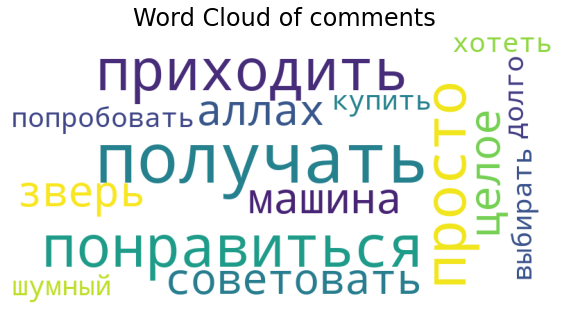

In [31]:
def plot_wordcloud(preprocessed_comments, mask=None, max_words=15, max_font_size=100, figure_size=(8.0,8.0), 
                   title = None, title_size=24, image_color=False):
    stopwords = {}
    wordcloud = WordCloud(background_color='white',
                    mask=None,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 666,
                    contour_width=1,
                    contour_color='black',
                    width=800, 
                    height=400,
                    )
    wordcloud.generate(str(preprocessed_comments))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
plot_wordcloud(preprocessed_comments, title="Word Cloud of comments")

# tf-idf

In [19]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

In [20]:
vectorized_comments = vectorizer.fit_transform(preprocessed_comments)

In [21]:
#  creating a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [22]:
#Эти слова показываем пользователю, он вводит то, по чему хочет почитать подробнее, или свое слово
tfidf.sort_values(by=['tfidf'], ascending=True).head(5)

,tfidf
приходить,2.476278
работать,2.578756
тесто,2.630428
довольный,2.653418
взбивать,2.785842


# Looking for most similar comments for each word

In [23]:
nlp = spacy.load('ru_core_news_lg')

In [24]:
def top_10_similar(word_for_checking, dataframe):
    critical_similarity_value = 0.47
    
    word_for_checking = nlp(word_for_checking)
    similarities = []
    for i in range(len(dataframe['lemma_comment'])):
        similarities.append(nlp(dataframe['lemma_comment'][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    #сортировка по убыванию similarities, фильтрация в соответствии с critical_similarity_value
    df_temp = df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)
    res = df_temp[df_temp[f'similarity_to_{word_for_checking}'] > critical_similarity_value][['comment', f'similarity_to_{word_for_checking}']]
    res = list(res['comment'])
    
    if len(res)>0:
        return res
    else: 
        return "По вашему запросу совпадений не найдено"

In [30]:
%time
start_time = time.time()
top_10_similar('белочка', df)
print("--- %s seconds ---" % (time.time() - start_time))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 25 µs


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  import sys


--- 22.96590304374695 seconds ---


In [26]:
# пока не работает с неизвестными словами, например, "маломерит"
# если пишешь плохое качество, то выдача вроде та же, что и на хорошее
# вся работа у меня заняла 30 секунд

In [45]:
df

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...
...,...,...,...,...,...,...,...,...,...,...
680,Это просто супер. Немогу нарадоваться ему. Раб...,2019-09-12T06:54:51.961383438Z,фиолетовый,0,5,4,5,Миксер стационарный SPM7167 1600Вт,StarWind,просто супер немогу нарадоваться ему работает ...
681,"18.07.2019 прибыл данный агрегат в наш дом, же...",2019-08-26T18:09:34.246907845Z,фиолетовый,0,8,0,5,Миксер стационарный SPM7167 1600Вт,StarWind,прибыл данный агрегат наш дом жена решила сраз...
682,Миксер просто бомба! Пришёл в двойной упаковке...,2019-08-24T09:31:08.725139922Z,фиолетовый,0,4,0,5,Миксер стационарный SPM7167 1600Вт,StarWind,просто бомба пришёл двойной упаковке всё налич...
683,"Вчера получила миксер,муж подарил на 30 летие ...",2019-07-06T07:34:02.483280032Z,фиолетовый,0,5,2,5,Миксер стационарный SPM7167 1600Вт,StarWind,вчера получила миксер муж подарил летие совмес...


# Vocabularly analisis

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [44]:
voc={}
count=0
for i in (df['lemma_comment']):
    for j in i.split(' '):
      
        if j not in voc:
            voc[j]=count
            count+=1

KeyError: 'lemma_comment'

In [72]:
count_vect = CountVectorizer(vocabulary=voc)
dataset = count_vect.fit_transform(df['lemma_comment'])

In [73]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components = 40, max_iter=40, n_jobs=6, learning_method='batch', verbose=1)
lda.fit(dataset)

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40
iteration: 31 of max_iter: 40
iteration: 32 of max_iter: 40
iteration: 33 of max_iter: 40
iteration: 34 of ma

LatentDirichletAllocation(max_iter=40, n_components=40, n_jobs=6, verbose=1)